In [1]:
import time
import math
import scipy
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from scipy import optimize
from tqdm import trange, tqdm
from matplotlib import animation

from IPython.display import clear_output

In [2]:
target_filename = "woman.jpg"
source_filename = "chameleon.jpg"
target_img = Image.open("../inputs/" + target_filename)
source_img = Image.open("../inputs/" + source_filename)
source_img = source_img.resize(target_img.size)

In [3]:
target_arr = np.array(target_img)
source_arr = np.array(source_img)

d0, d1, _ = source_arr.shape
source_arr = source_arr[:d0//20*20, :d1//20*20,:]
target_arr = target_arr[:d0//20*20, :d1//20*20,:]

In [4]:
# previous method
def previous_transfer_pixel(source_arr, target_arr, O=25):
    rows, cols, _ = source_arr.shape
    r = rows // O
    c = cols // O
            
    cost_matrix = np.empty((r,c,r,c))
    for i in range(r):
        for j in range(c):
            avg_skel = np.average(target_arr[i*O:i*O+O, j*O:j*O+O], axis=(0,1))
            for i2 in range(r):
                for j2 in range(c):
                    avg_fill = np.average(source_arr[i2*O:i2*O+O, j2*O:j2*O+O], axis=(0,1))
                    cost_matrix[i,j,i2,j2] = np.linalg.norm(avg_fill - avg_skel)


    temp = cost_matrix.reshape(r, c, r*c).transpose(2,0,1).reshape(r*c, r*c).transpose(1,0)
    _, col_ind = optimize.linear_sum_assignment(temp)

    coords = col_ind.reshape(r,c)

    final_arr = np.full((rows, cols, 3), 255, dtype=int)

    for i in range(r):
        for j in range(c):
            temp = coords[i,j]
            i2 = temp // c
            j2 = temp % c
            
            final_arr[i*O:i*O+O, j*O:j*O+O] = source_arr[i2*O:i2*O+O, j2*O:j2*O+O].copy()
    return coords, final_arr

In [5]:
# our method
def transfer_pixel(imgSrc, imgTar, B=25):
    if len(imgTar.shape) == 2:
        rows, cols = imgTar.shape
        ch = 1
        final_arr = np.full((rows, cols), 255, dtype=imgSrc.dtype)
    else:
        rows, cols, ch = imgTar.shape
        final_arr = np.full((rows, cols, ch), 255, dtype=imgSrc.dtype)
    
    r = rows // B
    c = cols // B
            
    cost_matrix = np.empty((r,c,r,c,ch))

    srcAvg = np.empty((r,c,ch))
    tarAvg = np.empty((r,c,ch))

    for i in range(r):
        for j in range(c):
            srcAvg[i,j] = np.average(imgSrc[i*B:i*B+B, j*B:j*B+B], axis=(0,1))
            tarAvg[i,j] = np.average(imgTar[i*B:i*B+B, j*B:j*B+B], axis=(0,1))

    for i in range(r):
            for j in range(c):
                cost_matrix[i,j] = tarAvg[i,j] -  srcAvg

    cost_matrix = np.linalg.norm(cost_matrix, axis=-1)


    temp = cost_matrix.reshape(r, c, r*c).transpose(2,0,1).reshape(r*c, r*c).transpose(1,0)
    _, col_ind = optimize.linear_sum_assignment(temp)

    coords = col_ind.reshape(r,c)

    for i in range(r):
        for j in range(c):
            temp = coords[i,j]
            i2 = temp // c
            j2 = temp % c
            
            final_arr[i*B:i*B+B, j*B:j*B+B] = imgSrc[i2*B:i2*B+B, j2*B:j2*B+B].copy()
    
    return coords, final_arr

In [6]:
coords_prev, final_arr_block_prev = previous_transfer_pixel(source_arr, target_arr, O=25)
coords, final_arr_block = transfer_pixel(source_arr, target_arr, B=25)

In [7]:
print(np.all(coords_prev == coords))
print(np.all(final_arr_block == final_arr_block_prev))

True
True


In [33]:
B_list = [20, 25, 30, 40, 50, 60, 70, 80, 90, 100]
old_method_time = []
new_method_time = []
for B in B_list:
    n = (B ** 3) // (24 ** 3) + 1
    print("B: %d, number of repeat for averaging: %d" % (B, n))
    t = time.time()
    for _ in range(n):
        previous_transfer_pixel(source_arr, target_arr, O=B)
    old_method_time.append((time.time() - t)/n)

    t = time.time()
    for _ in range(n):
        transfer_pixel(source_arr, target_arr, B=B)
    new_method_time.append((time.time() - t)/n)

old_method_time = np.array(old_method_time)
new_method_time = np.array(new_method_time)

B: 20, number of repeat for averaging: 1
B: 25, number of repeat for averaging: 2
B: 30, number of repeat for averaging: 2
B: 40, number of repeat for averaging: 5
B: 50, number of repeat for averaging: 10
B: 60, number of repeat for averaging: 16
B: 70, number of repeat for averaging: 25
B: 80, number of repeat for averaging: 38
B: 90, number of repeat for averaging: 53
B: 100, number of repeat for averaging: 73


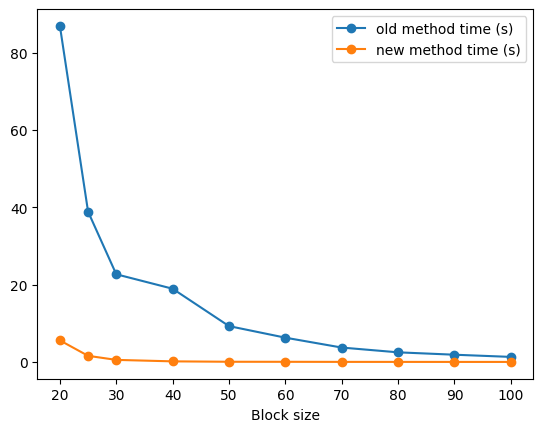

In [35]:
plt.plot(B_list, old_method_time, marker='o', label="old method time (s)")
plt.plot(B_list, new_method_time, marker='o', label="new method time (s)")
plt.legend()
plt.xlabel("Block size")

plt.show()

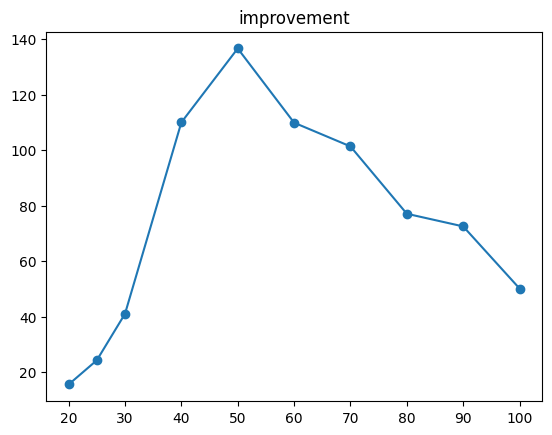

In [36]:
plt.title("improvement")
plt.plot(B_list, old_method_time / new_method_time, marker='o')
plt.show()